## Skin Disease prediction


In [56]:
!pip install pydot graphviz

### Installing required libraries

In [47]:
# ---------------------- LIBRARY IMPORTS ----------------------
import os  # Provides functions to interact with the operating system (used for directory paths)
import pandas as pd  # For handling structured data (tables, dataframes)
import numpy as np  # For numerical operations and arrays
import keras  # Keras is a high-level deep learning API
import warnings  # To handle warning messages
warnings.filterwarnings(action="ignore")  # Ignores any warning messages to keep the output clean

import matplotlib.pyplot as plt  # For visualizing images and plots
%matplotlib inline  
#(Jupyter notebook specific) - allows images to show inside notebook cells
import seaborn as sns  # Data visualization library for beautiful plots

# ---------------------- KERAS / TENSORFLOW LAYERS IMPORT ----------------------
from keras.models import Sequential  # Used to build a linear stack of neural network layers
from keras.layers import Dense, Dropout, Flatten  # Common layers for neural networks
from keras.layers import Conv2D, MaxPooling2D  # Convolution and pooling layers for CNN
from keras import backend as K  # Backend engine for Keras (TensorFlow, Theano, etc.)

# ---------------------- PREPROCESSING, SPLIT AND METRICS ----------------------
from sklearn.preprocessing import StandardScaler  # Normalize data
from sklearn.model_selection import train_test_split  # Split dataset into train/test sets
from sklearn.metrics import classification_report  # Evaluate model performance

# ---------------------- TENSORFLOW SPECIFIC IMPORTS ----------------------
import tensorflow as tf  # TensorFlow backend
from tensorflow import keras  # TensorFlow's Keras API
from tensorflow.keras.models import Sequential  # Define sequential models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense  # Layers for CNN
from tensorflow.keras.applications.vgg19 import VGG19  # Pre-trained CNN model (not used further in this code)
from tensorflow.keras.optimizers import Adam  # Optimizer
from tensorflow.keras.losses import SparseCategoricalCrossentropy  # Loss function for multi-class
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Image preprocessing utility
from tensorflow.keras.callbacks import TensorBoard,EarlyStopping  # Callbacks for training
import sklearn.metrics as metrics  # More metrics
from keras.callbacks import LearningRateScheduler  # Dynamic learning rate scheduling

# Learning rate decreases gradually over time (Annealing)
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)


In [48]:
base_dir = os.getcwd()
print(base_dir) 

/Users/kasish/Desktop/JASVEMLKNPR - PROJECT/DL-Project/notebook


### Creating a dataframe by labeling all images based on different categories

In [50]:
# Set base directory path to current working directory
base_dir = os.getcwd()

# Define paths to each skin disease class image folder
Eczema_dir = os.path.join(base_dir, "IMG_CLASSES", "1. Eczema 1677")
Warts_Molluscum_dir = os.path.join(base_dir, "IMG_CLASSES", "10. Warts Molluscum and other Viral Infections - 2103")
Atopic_Dermatitis_dir = os.path.join(base_dir, "IMG_CLASSES", "3. Atopic Dermatitis - 1.25k")
Melanocytic_Nevi_dir = os.path.join(base_dir, "IMG_CLASSES", "5. Melanocytic Nevi (NV) - 7970")
Psoriasis_pictures_dir = os.path.join(base_dir, "IMG_CLASSES", "7. Psoriasis pictures Lichen Planus and related diseases - 2k")
Seborrheic_Keratoses_Benign_Tumors_dir = os.path.join(base_dir, "IMG_CLASSES", "8. Seborrheic Keratoses and other Benign Tumors - 1.8k")
Tinea_Ringworm_Candidiasis_dir = os.path.join(base_dir, "IMG_CLASSES", "9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k")

# Initialize lists to store image filepaths and corresponding labels
filepaths = []
labels = []

# List of all directory paths
dict_list = [Eczema_dir, Warts_Molluscum_dir , Atopic_Dermatitis_dir, Melanocytic_Nevi_dir,Psoriasis_pictures_dir ,Seborrheic_Keratoses_Benign_Tumors_dir ,Tinea_Ringworm_Candidiasis_dir]

# Class label names for each folder (used to tag each image correctly)
class_labels = ['Eczema', 'Warts Molluscum', 'Atopic Dermatitis','Melanocytic Nevi', 'Psoriasis pictures', 'Seborrheic Keratoses Benign Tumors','Tinea Ringworm Candidiasis']

# Loop through each directory, collect image file paths and attach respective labels
for i, j in enumerate(dict_list):
    flist = os.listdir(j) # List of all image files in that folder(Provided directory)
    for f in flist:
        fpath = os.path.join(j, f)
        filepaths.append(fpath)
        labels.append(class_labels[i])

# Convert file paths and labels into pandas Series
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")

# Combine into a DataFrame (our master image-label mapping file)
skin_data = pd.concat([Fseries, Lseries], axis=1)
skin_df = pd.DataFrame(skin_data)

# View first few records
print(skin_df.head())

# Count of images per class label
print(skin_df["labels"].value_counts())

                                           filepaths  labels
0  /Users/kasish/Desktop/JASVEMLKNPR - PROJECT/DL...  Eczema
1  /Users/kasish/Desktop/JASVEMLKNPR - PROJECT/DL...  Eczema
2  /Users/kasish/Desktop/JASVEMLKNPR - PROJECT/DL...  Eczema
3  /Users/kasish/Desktop/JASVEMLKNPR - PROJECT/DL...  Eczema
4  /Users/kasish/Desktop/JASVEMLKNPR - PROJECT/DL...  Eczema
labels
Melanocytic Nevi                      7970
Warts Molluscum                       2103
Psoriasis pictures                    2055
Seborrheic Keratoses Benign Tumors    1847
Tinea Ringworm Candidiasis            1702
Eczema                                1677
Atopic Dermatitis                     1257
Name: count, dtype: int64


In [51]:
skin_df.shape

(18611, 2)

### Spliting the data into training data,testing data and the validation data

In [52]:
# Split the dataset into train and test sets (70%-30%)
train_images, test_images = train_test_split(skin_df, test_size=0.3, random_state=42)

# Split again into validation (20% of total dataset)
train_set, val_set = train_test_split(skin_df, test_size=0.2, random_state=42)

In [53]:
print(train_set.shape)
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(14888, 2)
(5584, 2)
(3723, 2)
(13027, 2)


### Creating a Image set,Training set, Testing set and Validation set generator

In [ ]:
# Image Generator to preprocess images and feed into model
image_gen = ImageDataGenerator(preprocessing_function= tf.keras.applications.mobilenet_v2.preprocess_input) # Specific normalization/rescales pixel value for MobileNetV2

# Train set generator
train = image_gen.flow_from_dataframe(dataframe= train_set,x_col="filepaths",# Column with image paths
                                      y_col="labels",# Column with labels
                                      target_size=(244,244), # Resize all images to 244x244 pixels
                                      color_mode='rgb', # Use color images
                                      class_mode="categorical", # For multi-class classification
                                      batch_size=32, # Process 32 images at a time
                                      shuffle=False            #do not shuffle data and Keep original order (for inspection)

                                   )

# Test set generator
test = image_gen.flow_from_dataframe(dataframe= test_images,x_col="filepaths", y_col="labels",
                                     target_size=(244,244),
                                     color_mode='rgb',
                                     class_mode="categorical",
                                     batch_size=32,
                                     shuffle= False
                                    )
# Validation set generator
val = image_gen.flow_from_dataframe(dataframe= val_set,x_col="filepaths", y_col="labels",
                                    target_size=(244,244),
                                    color_mode= 'rgb',
                                    class_mode="categorical",
                                    batch_size=32,
                                    shuffle=False
                                   )

Found 14888 validated image filenames belonging to 7 classes.
Found 5584 validated image filenames belonging to 7 classes.
Found 3723 validated image filenames belonging to 7 classes.


In [61]:
classes=list(train.class_indices.keys())
print (classes)

['Atopic Dermatitis', 'Eczema', 'Melanocytic Nevi', 'Psoriasis pictures', 'Seborrheic Keratoses Benign Tumors', 'Tinea Ringworm Candidiasis', 'Warts Molluscum']


In [58]:
# Import required libraries
import matplotlib.pyplot as plt  # Used for plotting and visualizing images
import numpy as np  # Used for numerical operations, such as finding max index

def show_Skin_images(image_gen):
    """
    This function displays a batch of images from the provided image generator along with their labels.
    
    Parameters:
    image_gen (Iterator): A generator object that yields batches of images and their corresponding labels.
    
    Returns:
    None (Displays images in a grid format)
    """

    # Retrieve class labels from the test dataset
    test_dict = test.class_indices  # Gets a dictionary mapping class names to their index positions
    classes = list(test_dict.keys())  # Extracts class names as a list
    
    # Retrieve a batch of images and labels from the generator
    images, labels = next(image_gen)  # `next(image_gen)` fetches the next batch from the generator

    # Create a new figure with a specified size (width=20, height=20 inches)
    plt.figure(figsize=(20, 20))

    # Determine the number of images in the batch
    length = len(labels)

    # Ensure that a maximum of 25 images are displayed (or fewer if batch size is smaller)
    if length < 25:
        r = length  # If batch has fewer than 25 images, use batch size as limit
    else:
        r = 25  # Otherwise, limit the display to 25 images

    # Loop over the number of images to be displayed
    for i in range(r):
        # Create subplots in a 5x5 grid
        plt.subplot(5, 5, i + 1)

        # Normalize the image values from [-1, 1] to [0, 1] for correct display
        image = (images[i] + 1) / 2  

        # Display the image
        plt.imshow(image)

        # Determine the class index from the one-hot encoded label
        index = np.argmax(labels[i])  # Finds the index of the maximum value (i.e., the class label)

        # Retrieve the class name corresponding to the index
        class_name = classes[index]

        # Set the title of the image (i.e., its class label)
        plt.title(class_name, color="green", fontsize=18, fontweight='bold', pad=12)  # Green title with adjustments

        # Remove axis ticks for a cleaner look
        plt.axis('off')

    # Adjust spacing between subplots for better readability
    plt.subplots_adjust(wspace=0.5, hspace=0.6)

    # Display all images in the grid
    plt.show()

# Call the function with `train` dataset generator to visualize images
show_Skin_images(train)


FileNotFoundError: [Errno 2] No such file or directory: '/Users/kasish/Desktop/JASVEMLKNPR - PROJECT/DL-Project/notebook/IMG_CLASSES/3. Atopic Dermatitis - 1.25k/1_3.jpg'

In [57]:
num_classes = len(classes)


### Model Building

In [ ]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load pre-trained MobileNetV2 (trained on 1.4M ImageNet images)
base_model = MobileNetV2(weights='imagenet', # Use pre-trained weights
                         include_top=False, # Don't include final classification layer
                         input_shape=(244, 244, 3)) # Expected input format

# Freeze base layers (prevent weights from updating)
for layer in base_model.layers:
    layer.trainable = False

# Build a new model on top of the pre-trained base
def build_transfer_learning_model(num_classes):
    model = Sequential([
        base_model, # Pre-trained base
        GlobalAveragePooling2D(), # Reduce spatial dimensions
        Dense(512, activation='relu'), # New trainable layer
        Dropout(0.5), # Randomly disable 50% neurons to prevent overfitting
        Dense(num_classes, activation='softmax') # Final layer with num_classes i.e. 7 outputs (for 7 classes)
    ])

    # Compile model with settings
    model.compile(optimizer=Adam(learning_rate=0.001), # Optimization algorithm
                  loss='categorical_crossentropy', # Loss function for multi-class
                  metrics=['accuracy']) # Track accuracy during training

    return model

# Build the transfer learning model
transfer_learning_model = build_transfer_learning_model(num_classes)

# Learning rate schedule callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', # Watch validation loss
                              factor=0.2, # Reduce LR(learning rate) by 80% when improvement stops
                              patience=3, # Wait 3 epochs before reducing
                              min_lr=1e-6)  # Minimum learning rate

# Train model for 15 cycles (epochs)
history_transfer_learning = transfer_learning_model.fit(train, # Training data
                                                        epochs=15, # Full passes through dataset
                                                        validation_data=val, # Validation data
                                                        callbacks=[reduce_lr]) # Learning rate adjustment

# Evaluation on the test set
test_loss, test_accuracy = transfer_learning_model.evaluate(test)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Epoch 1/15
466/466 [==============================] - 115s 246ms/step - loss: 0.9371 - accuracy: 0.6391 - val_loss: 0.7764 - val_accuracy: 0.6908 - lr: 0.0010
Epoch 2/15
466/466 [==============================] - 126s 269ms/step - loss: 0.7921 - accuracy: 0.6910 - val_loss: 0.7363 - val_accuracy: 0.7110 - lr: 0.0010
Epoch 3/15
466/466 [==============================] - 132s 284ms/step - loss: 0.7371 - accuracy: 0.7176 - val_loss: 0.7096 - val_accuracy: 0.7188 - lr: 0.0010
Epoch 4/15
466/466 [==============================] - 146s 314ms/step - loss: 0.6947 - accuracy: 0.7347 - val_loss: 0.7130 - val_accuracy: 0.7255 - lr: 0.0010
Epoch 5/15
466/466 [==============================] - 138s 297ms/step - loss: 0.6618 - accuracy: 0.7468 - val_loss: 0.6712 - val_accuracy: 0.7387 - lr: 0.0010
Epoch 6/15
466/466 [==============================] - 146s 314ms/step - loss: 0.6253 - accuracy: 0.7655 - val_loss: 0.6723 - val_accuracy: 0.7427 - lr: 0.0010
Epoch 7/15
466/466 [==========================

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 3591      
                                                                 
Total params: 2917447 (11.13 MB)
Trainable params: 65946

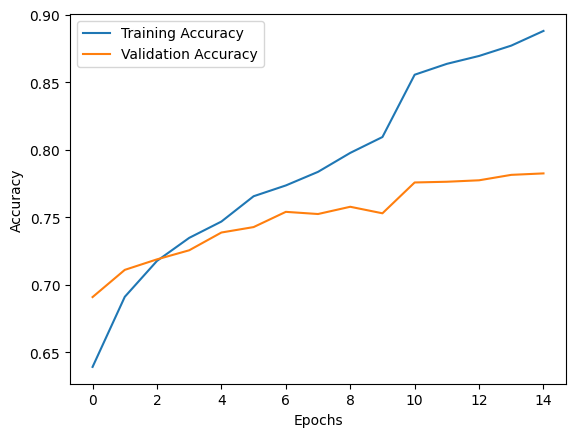

In [24]:
transfer_learning_model.summary()
plt.plot(history_transfer_learning.history['accuracy'], label='Training Accuracy')
plt.plot(history_transfer_learning.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

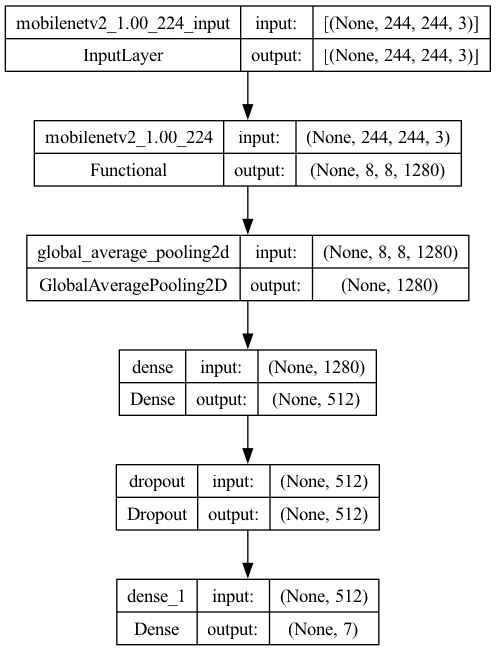

In [36]:
from keras.utils import plot_model
plot_model(transfer_learning_model, to_file='transfer_learning_model_plot.png', show_shapes=True, show_layer_names=True)

### Evaluation

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
pred2 = transfer_learning_model.predict(test) # Get probability scores
y_pred = np.argmax(pred2, axis=1) # Convert to class indices (0-6)
y_true = test.labels

# Generate performance report
print(classification_report(y_true, y_pred))
accuracy = accuracy_score(y_true, y_pred) * 100
print("Accuracy of the Model: {:.1f}%".format(accuracy))

175/175 [==============================] - 33s 185ms/step
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       382
           1       0.70      0.66      0.68       500
           2       1.00      1.00      1.00      2384
           3       0.67      0.70      0.68       650
           4       0.77      0.77      0.77       557
           5       0.69      0.69      0.69       492
           6       0.73      0.74      0.73       619

    accuracy                           0.83      5584
   macro avg       0.75      0.74      0.75      5584
weighted avg       0.83      0.83      0.83      5584

Accuracy of the Model: 83.1%


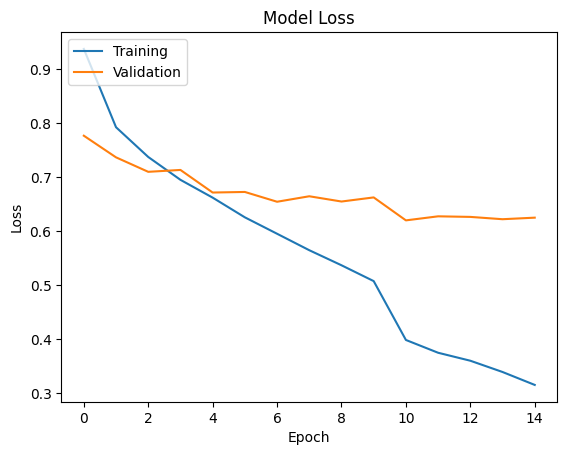

In [27]:
plt.plot(history_transfer_learning.history['loss'])
plt.plot(history_transfer_learning.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

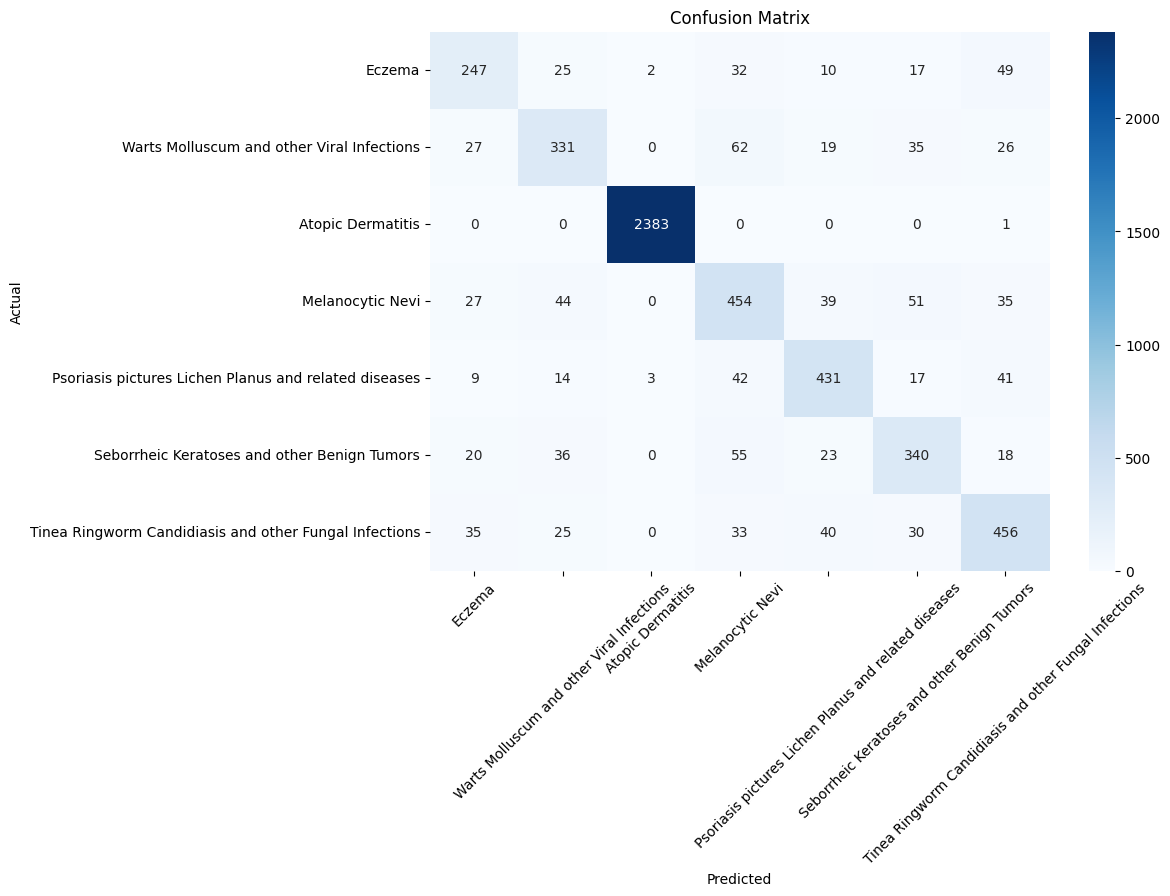

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

class_labels = ['Eczema', 'Warts Molluscum and other Viral Infections', 'Atopic Dermatitis', 'Melanocytic Nevi', 'Psoriasis pictures Lichen Planus and related diseases', 'Seborrheic Keratoses and other Benign Tumors','Tinea Ringworm Candidiasis and other Fungal Infections']

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualize prediction distribution
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues')

# Set ticks at the center of each class
tick_positions = [i + 0.5 for i in range(len(class_labels))]
plt.xticks(ticks=tick_positions, labels=class_labels, rotation=45)
plt.yticks(ticks=tick_positions, labels=class_labels, rotation=0)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()

### Save Model

In [ ]:
transfer_learning_model.save("SKIN Diseases.h5") # Save entire model architecture + weights